In [1]:
import pandas as pd

# 1.) Clean the Apple Data to get a quarterly series of EPS.

In [6]:
y = pd.read_csv("AAPL_quarterly_financials.csv")

In [7]:
y.index = y.name

In [8]:
y = pd.DataFrame(y.loc["BasicEPS", :]).iloc[2:,:]

In [9]:
y.index = pd.to_datetime(y.index)

In [10]:
# CHECK IF NAS ARE NO DIVIDEND PERIOD
y = y.sort_index().fillna(0.)

# 2.) Come up with 6 search terms you think could nowcast earnings. (Different than the ones I used) Add in 3 terms that that you think will not Nowcast earnings. Pull in the gtrends data

In [11]:
from pytrends.request import TrendReq

In [70]:
# Create pytrends object
pytrends = TrendReq(hl='en-US', tz=360)

# Set up the keywords and the timeframe
keywords = ["iPhone","Instagram","Airpods","Apple",
            "Release","Interest Rates", "UCLA", "Muffin","Pets"]  # Add your keywords here
start_date = '2004-01-01'
end_date = '2024-01-01'

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Iterate through keywords and fetch data
for keyword in keywords:
    pytrends.build_payload([keyword], cat=0, timeframe=
                           f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    df[keyword] = interest_over_time_df[keyword]

In [71]:
df = df.resample("Q").mean()

In [72]:
# ALIGN DATA
temp = pd.concat([y, df],axis = 1).dropna()
y = temp[["BasicEPS"]].copy()
X = temp.iloc[:,1:].copy()

# 3.) Normalize all the X data

In [73]:
from sklearn.preprocessing import StandardScaler

In [74]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4.) Run a Lasso with lambda of .5. Plot a bar chart.

In [75]:
from sklearn.linear_model import Lasso

In [85]:
lasso = Lasso(alpha = .05)
lasso.fit(X_scaled, y)

Lasso(alpha=0.05)

In [86]:
coefficients = lasso.coef_

In [87]:
import matplotlib.pyplot as plt

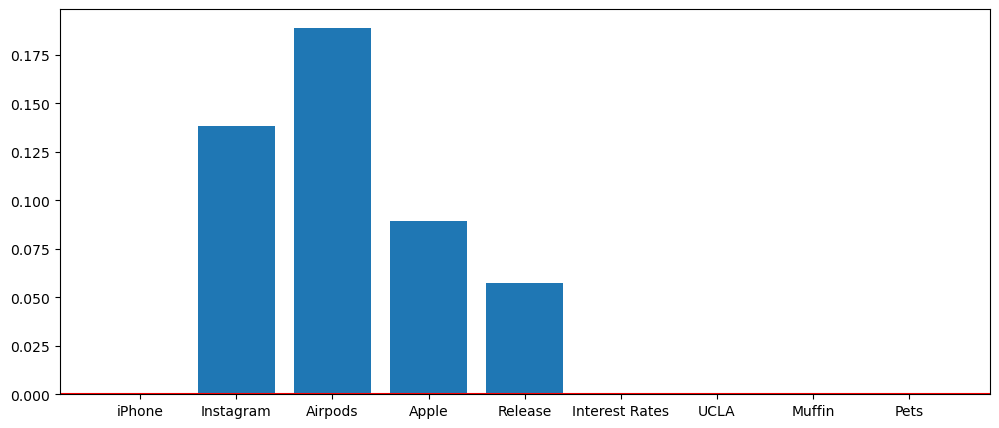

In [88]:
plt.figure(figsize = (12,5))
plt.bar(range(len(coefficients)), coefficients)
plt.axhline(0, color = "red")
plt.xticks(range(len(coefficients)), X.columns)
plt.show()

# 5.) Do these coefficient magnitudes make sense?

The lambda parameter in Lasso regression dictates the penalty's severity imposed on the coefficient sizes. Setting alpha to 0.5 applies a more substantial penalty, resulting in all coefficients being shrunk to zero, indicating that the search terms, in this scenario, do not exert a significant influence on Apple's EPS.

With lambda set to 0.05, however, the coefficients' magnitudes appear more rational. These coefficients, both in magnitude and sign, offer insights into each term's potential impact on the predicted EPS. As depicted in the bar chart, terms like 'Instagram', 'AirPods', 'Apple', and 'Release' possess positive coefficients in relation to Apple's EPS. This correlation is logical as they represent media exposure and consumer interest in Apple or its products, which could positively affect earnings.

Conversely, arbitrary terms without a direct link to Apple's earnings or share count, such as 'UCLA', 'Muffin', and 'Pets', are appropriately assigned coefficients of zero. This suggests that the Lasso model is accurately recognizing their lack of significant correlation with Apple's EPS. Surprisingly, 'iPhone' has a coefficient near zero, which may be attributed to variations in spelling or other factors that obscure its identification.